## SkyCalc interface

The `SkyCalcInterface` provides a high-level interface to ESO's `SkyCalc` tool through their `skycalc_cli` utility. This means that `skycalc_cli` is required for this interface. The interface uses the parameters given to create two output `Field`s: the emission as a function of wavelength and the atmospheric transmission as a function of wavelength.

An important note: this interface is bound to the same limitations as SkyCalc itself. In particular, this interface supports observatories at an arbitrary location on Earth, but the SkyCalc model has only been verified on a few sites (of which Paranal is the default). The results from SkyCalc may differ significantly from measured atmospheric properties for other telescope sites.

In [1]:
#------ manually fix import
import sys
import pathlib

parent_folder = pathlib.Path().absolute().parents[0]
sys.path.append(str(parent_folder))
#------
import matplotlib.pyplot as plt
import astropy.units as u
import obsim as obs
from astropy.io import fits
from astropy.time import Time
import astropy.coordinates as c

We start by defining the wavelength range we'll be using.

In [2]:
wavelengths = obs.make_wavelengths(200000, 'R')

SkyCalc has a lot of free parameters, most of which have all been added as properties to the `SkyCalcInterface`.

In [3]:
print(list(obs.SkyCalcInterface.property_list))

['pwv_mode', 'pwv', 'msolflux', 'incl_moon', 'moon_earth_dist', 'incl_starlight', 'incl_zodiacal', 'ecl_lon', 'ecl_lat', 'incl_loweratm', 'incl_upperatm', 'incl_airglow', 'incl_therm', 'therm_t1', 'therm_e1', 'therm_t2', 'therm_e2', 'therm_t3', 'therm_e3', 'vacair', 'wmin', 'wmax', 'wgrid_mode', 'wdelta', 'wres', 'lsf_type', 'lsf_gauss_fwhm', 'lsf_boxcar_fwhm', 'observatory', 'target_alt', 'moon_alt', 'moon_target_sep', 'moon_sun_sep']


These properties are mostly the same as for the `skycalc_cli` tool, whose documentation can be found at https://www.eso.org/observing/etc/doc/skycalc/helpskycalccli.html. Limits or allowed values can also be found in the `property_list`.

In [4]:
print(obs.SkyCalcInterface.property_list['moon_earth_dist'])

{'type': <class 'float'>, 'default': 1.0, 'limits': [0.91, 1.08]}


One notable exception where the interface differs from `skycalc_cli` is in the requirement for a target altitude, which is held by the `target_alt` property, rather than a specified airmass as required by `skycalc_cli`.

There are two ways of using the interface, one with a `Telescope` and one without. First we will look at using the interface
without a `Telescope`. As all the parameters have defaults attached to them, it is possible to create an instance of the interface and immediately make the resulting emission and transmission `Fields`.

In [5]:
interface = obs.SkyCalcInterface()
emission, transmission = interface.make_fields()

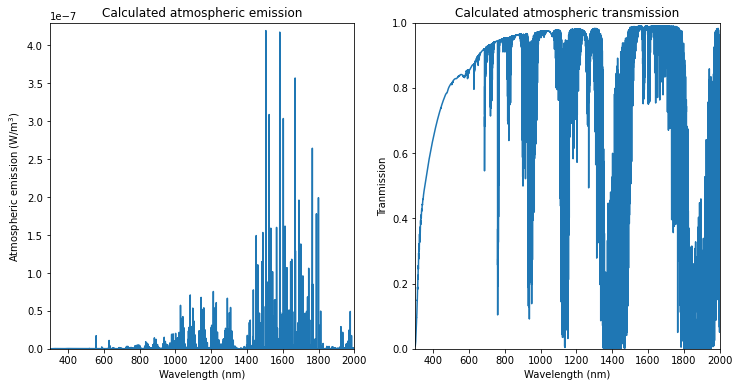

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].plot(emission.grid.coords[0].to(u.nm), emission)
axs[0].set_xlabel(r"Wavelength (nm)")
axs[0].set_ylabel(r"Atmospheric emission (W/m$^3$)")
axs[0].set_title("Calculated atmospheric emission")
axs[0].set_xlim([300,2000])
axs[0].set_ylim([0,4.3E-7])

axs[1].plot(transmission.grid.coords[0].to(u.nm), transmission)
axs[1].set_xlabel(r"Wavelength (nm)")
axs[1].set_ylabel("Tranmission")
axs[1].set_title("Calculated atmospheric transmission")
axs[1].set_xlim([300,2000])
axs[1].set_ylim([0,1])

plt.show()

Note that the interface has also chosen a default wavelength range, which is between 300 and 2000 nm with a step of 0.1 nm. Unfortunately it is not possible to supply a custom wavelength set to `skycalc_cli`, but there is some limited control over the wavelength range. It is possible to change the wavelength range with the `wmin`, `wamx`, `wres`, `wdelta`, and `wgrid_mode` properties. Alternatively, it is possible to set these parameters based on a supplied wavelength range using the `set_wavelengths` method or by supplying the wavelengths directly to the `make_fields` method.

Typically, the most important parameter to vary is the airmass. Here we do this by setting the desired target altitude through `target_alt`, given as an angle above the horizon (so 90 degrees corresponds to the target being at zenith, and negative angles mean the target is below the horizon).

In [7]:
interface = obs.SkyCalcInterface()
interface.target_alt = 30*u.deg
emission, transmission = interface.make_fields(wavelengths)

(0.0, 1.0)

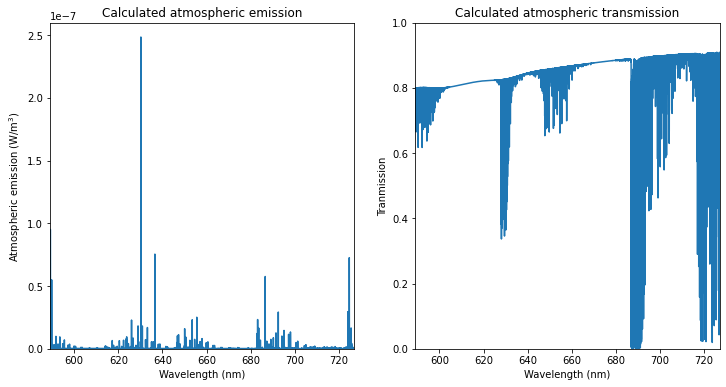

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].plot(emission.grid.coords[0].to(u.nm), emission)
axs[0].set_xlabel(r"Wavelength (nm)")
axs[0].set_ylabel(r"Atmospheric emission (W/m$^3$)")
axs[0].set_title("Calculated atmospheric emission")
axs[0].set_xlim([658-138/2,658+138/2])
axs[0].set_ylim([0,2.6E-7])

axs[1].plot(transmission.grid.coords[0].to(u.nm), transmission)
axs[1].set_xlabel(r"Wavelength (nm)")
axs[1].set_ylabel("Tranmission")
axs[1].set_title("Calculated atmospheric transmission")
axs[1].set_xlim([658-138/2,658+138/2])
axs[1].set_ylim([0,1])

The second way of using the interface is with a `Telescope`. The `Telescope` must be set with a physical location, pointed to a target with a physical location, and have an observation time, so it has a definite pointing. How to do this is also explained in the 'Physical Sources' example.

In [9]:
# source
loc = c.SkyCoord.from_name('M33')
source = obs.Source(wavelengths, location = loc)

# telescope
lam = 1*u.um
F = 10
D = 1*u.m

offset = 2*u.hour # correction for UTC
exp_time = Time('2021-6-29 02:30:00') - offset

telescope_location = c.EarthLocation(lat=52.154902*u.deg, lon=4.483179*u.deg, 
                                     height=20*u.m)

t = obs.Telescope(diameter = D, q=4, field_of_view = 3*u.arcsec, 
                  f_number = F, reference_wavelength=lam, 
                  location=telescope_location, observation_time = exp_time)
t.point_at(source)


To use the interface with a `Telescope`, simply pass it to the interface when initializing it. Using the properties from the `Telescope` and `Source` above, the target altitude and moon and sun locations are automatically determined, instead of having to be set by hand. The inequality between moon altitude, target altitude, and moon/target separation (see the description of the parameters at https://www.eso.org/observing/etc/doc/skycalc/helpskycalccli.html) is also automatically satisfied as the set parameters are based on the physical locations for the target and moon.

In [10]:
interface = obs.SkyCalcInterface(t)
emission, transmission = interface.make_fields(wavelengths)

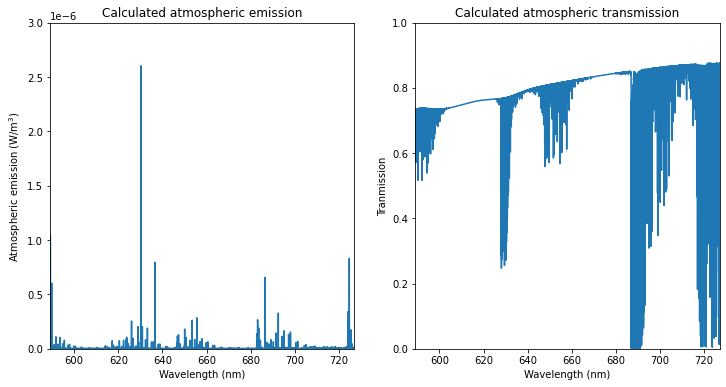

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].plot(emission.grid.coords[0].to(u.nm), emission)
axs[0].set_xlabel(r"Wavelength (nm)")
axs[0].set_ylabel(r"Atmospheric emission (W/m$^3$)")
axs[0].set_title("Calculated atmospheric emission")
axs[0].set_xlim([658-138/2,658+138/2])
axs[0].set_ylim([0,3E-6])

axs[1].plot(transmission.grid.coords[0].to(u.nm), transmission)
axs[1].set_xlabel(r"Wavelength (nm)")
axs[1].set_ylabel("Tranmission")
axs[1].set_title("Calculated atmospheric transmission")
axs[1].set_xlim([658-138/2,658+138/2])
axs[1].set_ylim([0,1])


plt.show()